# Word2vec implementation in Keras

In [1]:
# Imports
import requests
import collections
import os
import zipfile
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)

import tensorflow as tf
tf.random.set_seed(rng_seed)
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Reshape, dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Silence NumbaPerformanceWarning (for UMAP)
from numba.errors import NumbaPerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# Clustering
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import hdbscan

### Utility functions

In [2]:
def load_text_data_from_url(url: str, data_dir: str = 'data'):
    '''Loads data from url. Data will be downloaded to disk if non-existent.
    
    Args:
        url: Url to fetch data from.
        data_dir: Data directory to download the data to.
        
    Returns:
        content: Text content of the data
    '''
    filename = f'{data_dir}{os.path.sep}{os.path.basename(url)}'
    
    # Download file if not present
    if not os.path.exists(filename):
        r = requests.get(url)
        with open(filename, 'wb', encoding='utf-8-sig') as f:
            f.write(r.content)
        return r.text
    else:
        with open(filename, 'r', encoding='utf-8-sig') as f:
            content = f.read()
    
    return content

In [3]:
def build_dataset(text: str, max_vocab_size: int, context_window_size: int, seed: int = None):
    '''
    TODO: Docs
    '''
    # Tokenize the text
    tokenizer = Tokenizer(max_vocab_size)
    tokenizer.fit_on_texts([text])
    text_tokenized = text_to_word_sequence(text)
    
    # Extract word dictionary
    word_dict = tokenizer.word_index
    num_words = len(word_dict)
    rev_word_dict = tokenizer.index_word
    data = [word_dict[word] for word in text_tokenized]
    
    # Create data samples for valid context words and negative samples
    sampling_table = make_sampling_table(num_words + 1)
    pairs, labels = skipgrams(data, num_words, window_size=context_window_size, sampling_table=sampling_table, seed=seed)
    pairs = np.array(pairs)
    labels = np.array(labels)
    
    return data, (pairs, labels), word_dict, rev_word_dict, num_words

In [4]:
# Constants
max_vocab_size = 10000
context_window_size = 10 # Change to 3-5
vector_dim = 300 # Change to 100-200 ish
num_epochs = 20
batch_size = 128
num_negative_samples = 5 # TODO: Implement this

In [5]:
# Build dataset
# TODO: Build separate datasets for train, val and test.
# Otherwhise the datasets will become too corrolated, due to the fact that
# we create skipgrams which might overlap a lot.
# TODO: Look into COVID-19 dataset from kaggle:
# https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge
book_url = 'http://www.gutenberg.org/cache/epub/78/pg78.txt'
book_content = load_text_data_from_url(book_url)
book_data, (book_data_pairs, book_data_labels), book_dictionary, rev_book_dictionary, real_vocab_size = build_dataset(book_content, max_vocab_size, context_window_size)
book_data_pairs_hot = to_categorical(book_data_pairs, real_vocab_size + 1)
del book_content # Save memory

In [ ]:
# TODO: Create datagenerator for train and test.
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [73]:
real_vocab_size

7758

In [6]:
# Split data into train/test
X_train, X_val, y_train, y_val = train_test_split(book_data_pairs, book_data_labels, test_size=0.04, random_state=rng_seed)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=rng_seed)

In [74]:
len(X_train)

497819

In [9]:
# One-hot enode the data for Dense model
X_train_hot = to_categorical(X_train, real_vocab_size + 1)
X_val_hot = to_categorical(X_val, real_vocab_size + 1)
X_test_hot = to_categorical(X_test, real_vocab_size + 1)

In [10]:
# Sanity checking
for i, target, context, label in zip(range(10), X_train[:, 0], X_train[:, 1], book_data_labels):
    print(f'Pair #{i + 1} - {rev_book_dictionary[target]} + {rev_book_dictionary[context]} --> {label}')

Pair #1 - told + when --> 0
Pair #2 - education + swiftness --> 0
Pair #3 - animal + gourd --> 0
Pair #4 - occur + maze --> 0
Pair #5 - wool + hurried --> 1
Pair #6 - dimly + shadows --> 0
Pair #7 - combination + mayhem --> 0
Pair #8 - males + slink --> 0
Pair #9 - bewilderment + afternoon --> 1
Pair #10 - ere + wed --> 1


In [26]:
# Create the model
# TODO: Add regularization to layers
def build_model_embedding(vocab_size: int, vector_dim: int, optimizer='adam'):
    '''
    TODO: Docs
    '''
    # Input to network
    input_target = Input((1,), name='input_target')
    input_context = Input((1,), name='input_context')

    # Embedding layer
    embedding = Embedding(vocab_size + 1, vector_dim, input_length=1, name='embedding')
    target = embedding(input_target)
    target = Reshape((vector_dim, 1), name='target_word_vector')(target)
    context = embedding(input_context)
    context = Reshape((vector_dim, 1), name='context_word_vector')(context)
    
    # Compute similarity (dot product)
    dot_product = dot([target, context], axes=1, normalize=False, name='dot_product')
    dot_product = Reshape((1,), name='dot_product_reshape')(dot_product)
    
    # Sigmoid activation (output)
    output = Dense(1, activation='sigmoid', name='sigmoid_activation')(dot_product)
    
    # Create model
    model = Model(inputs=[input_target, input_context], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Create (slower) model using Dense instead of Embedding layer
def build_model_dense(vocab_size: int, vector_dim: int, optimizer='adam'):
    '''
    TODO: Docs
    '''
    # Input to network
    input_shape = (vocab_size + 1,)
    input_target = Input(input_shape, name='input_target')
    input_context = Input(input_shape, name='input_context')

    # Embedding layer using Dense layers
    embedding = Dense(vector_dim, input_shape=input_shape, name='embedding')
    target = embedding(input_target)
    target = Reshape((vector_dim, 1), name='target_word_vector')(target)
    context = embedding(input_context)
    context = Reshape((vector_dim, 1), name='context_word_vector')(context)
    
    # Compute similarity (dot product)
    dot_product = dot([target, context], axes=1, normalize=False, name='dot_product')
    dot_product = Reshape((1,), name='dot_product_reshape')(dot_product)
    
    # Sigmoid activation (output)
    output = Dense(1, activation='sigmoid', name='sigmoid_activation')(dot_product)
    
    # Create model
    model = Model(inputs=[input_target, input_context], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [27]:
w2v_model = build_model_dense(real_vocab_size, vector_dim)
w2v_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_target (InputLayer)       [(None, 7759)]       0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      [(None, 7759)]       0                                            
__________________________________________________________________________________________________
embedding (Dense)               (None, 300)          2328000     input_target[0][0]               
                                                                 input_context[0][0]              
__________________________________________________________________________________________________
target_word_vector (Reshape)    (None, 300, 1)       0           embedding[0][0]            

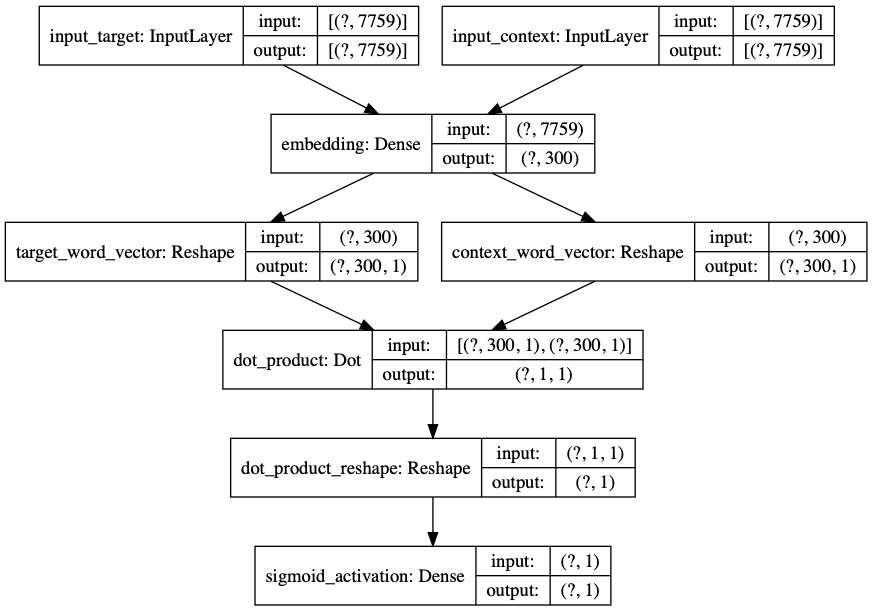

In [28]:
# Visualize model using PyDot and GraphViz
plot_model(w2v_model, show_shapes=True, to_file='word2vec_model.png')

In [29]:
# Load model from file
#w2v_model = load_model('word2vec_model.h5')

In [30]:
class IntermediateUMAPReductionCallback(Callback):
    '''
    TODO: Docs
    '''
    
    def __init__(self, plot_embedding: bool = True, data: list = None, rev_data_dictionary: dict = None):
        '''
        TODO: Docs
        '''
        self.plot_embedding = plot_embedding
        self.data = data
        self.rev_data_dictionary = rev_data_dictionary
        self.embeddings = []
    
    def get_embedding(self, epoch: int):
        '''
        TODO: Docs
        '''
        assert epoch < len(self.embeddings), f'Invalid epoch number: {epoch}'
        return self.embeddings[epoch]
    
    def __plot_embedding__(self, epoch: int, num_words: int = 100):
        '''
        TODO: Docs
        '''
        assert self.data != None, 'Data is required for plotting'
        assert self.rev_data_dictionary != None, 'Reversed data dictionary is required for plotting'
        embedding = self.get_embedding(epoch)
        
        # Plot embedded vectors in 2D
        plt.figure(figsize=(5, 5))
        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.25)

        # Annotate
        for word_i in self.data[:num_words]:
            word = self.rev_data_dictionary[word_i]
            word_vec = embedding[word_i]
            plt.annotate(word, (word_vec[0], word_vec[1]))
        plt.show()
    
    def on_epoch_end(self, epoch, logs={}):
        '''
        TODO: Docs
        '''
        print(f'Creating word embeddings...')
        
        # Create intermediate UMAP word embeddings
        word_embeddings = self.model.layers[2].get_weights()[0]
        word_embeddings_2d = umap.UMAP().fit_transform(word_embeddings)
        self.embeddings.append(word_embeddings_2d)
        
        if self.plot_embedding:
            self.__plot_embedding__(epoch)

Train on 497819 samples, validate on 10371 samples
Epoch 1/20
497536/497819 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4994
Epoch 00001: val_loss improved from inf to 0.69315, saving model to checkpoints/model-best-01.h5
Creating word embeddings...


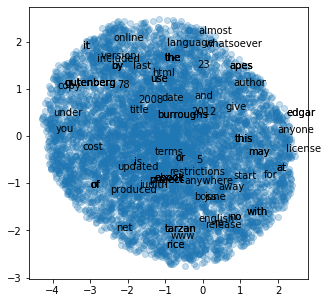

497819/497819 [==============================] - 128s 256us/sample - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 2/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.6362
Epoch 00002: val_loss did not improve from 0.69315
Creating word embeddings...


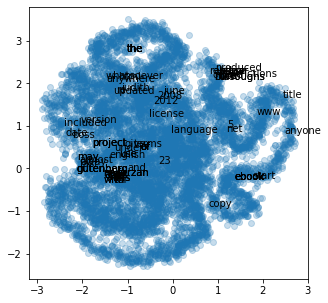

497819/497819 [==============================] - 123s 248us/sample - loss: 0.6463 - accuracy: 0.6363 - val_loss: 0.7505 - val_accuracy: 0.4931
Epoch 3/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.3210 - accuracy: 0.8717
Epoch 00003: val_loss did not improve from 0.69315
Creating word embeddings...


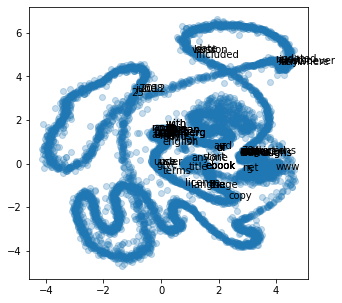

497819/497819 [==============================] - 119s 239us/sample - loss: 0.3210 - accuracy: 0.8717 - val_loss: 1.0753 - val_accuracy: 0.4968
Epoch 4/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.1864 - accuracy: 0.9247
Epoch 00004: val_loss did not improve from 0.69315
Creating word embeddings...


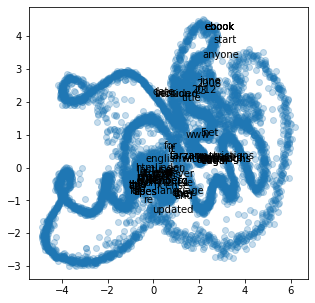

497819/497819 [==============================] - 119s 239us/sample - loss: 0.1864 - accuracy: 0.9247 - val_loss: 1.2326 - val_accuracy: 0.4919
Epoch 5/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9306
Epoch 00005: val_loss did not improve from 0.69315
Creating word embeddings...


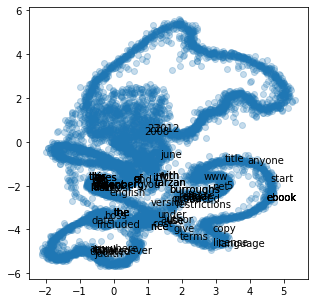

497819/497819 [==============================] - 119s 240us/sample - loss: 0.1694 - accuracy: 0.9306 - val_loss: 1.2977 - val_accuracy: 0.4889
Epoch 6/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9321
Epoch 00006: val_loss did not improve from 0.69315
Creating word embeddings...


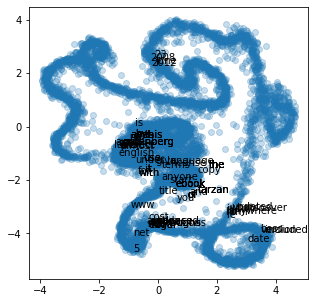

497819/497819 [==============================] - 121s 242us/sample - loss: 0.1597 - accuracy: 0.9321 - val_loss: 1.3243 - val_accuracy: 0.4888
Epoch 7/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9330
Epoch 00007: val_loss did not improve from 0.69315
Creating word embeddings...


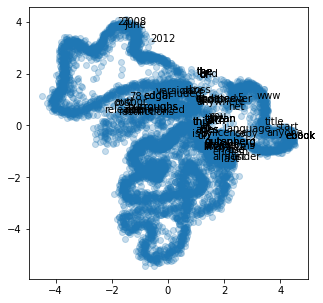

497819/497819 [==============================] - 119s 240us/sample - loss: 0.1532 - accuracy: 0.9330 - val_loss: 1.3543 - val_accuracy: 0.4894
Epoch 8/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9337
Epoch 00008: val_loss did not improve from 0.69315
Creating word embeddings...


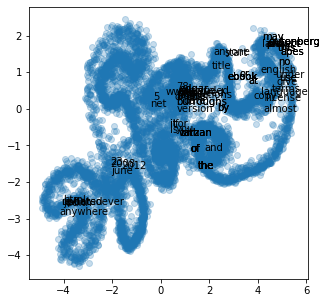

497819/497819 [==============================] - 120s 242us/sample - loss: 0.1480 - accuracy: 0.9337 - val_loss: 1.3670 - val_accuracy: 0.4923
Epoch 9/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9341
Epoch 00009: val_loss did not improve from 0.69315
Creating word embeddings...


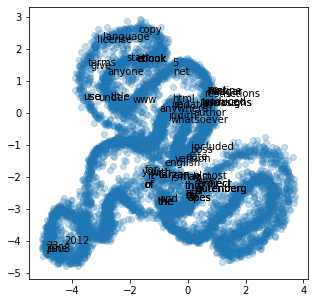

497819/497819 [==============================] - 120s 241us/sample - loss: 0.1437 - accuracy: 0.9341 - val_loss: 1.4070 - val_accuracy: 0.4924
Epoch 10/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1403 - accuracy: 0.9343
Epoch 00010: val_loss did not improve from 0.69315
Creating word embeddings...


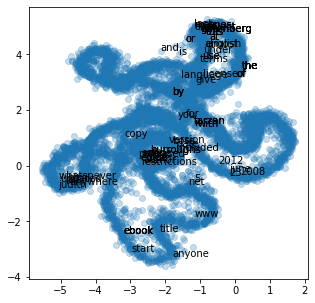

497819/497819 [==============================] - 120s 241us/sample - loss: 0.1403 - accuracy: 0.9343 - val_loss: 1.4383 - val_accuracy: 0.4930
Epoch 11/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1374 - accuracy: 0.9347
Epoch 00011: val_loss did not improve from 0.69315
Creating word embeddings...


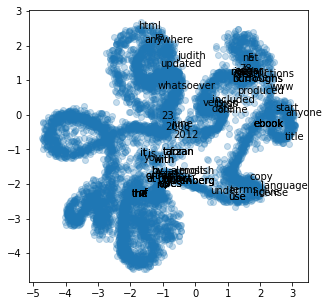

497819/497819 [==============================] - 120s 241us/sample - loss: 0.1375 - accuracy: 0.9347 - val_loss: 1.4603 - val_accuracy: 0.4880
Epoch 12/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9351
Epoch 00012: val_loss did not improve from 0.69315
Creating word embeddings...


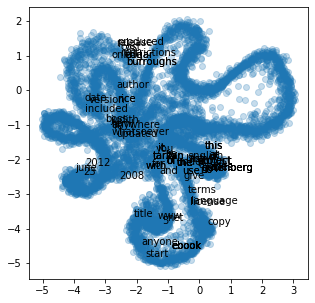

497819/497819 [==============================] - 120s 242us/sample - loss: 0.1348 - accuracy: 0.9351 - val_loss: 1.4819 - val_accuracy: 0.4915
Epoch 13/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9356
Epoch 00013: val_loss did not improve from 0.69315
Creating word embeddings...


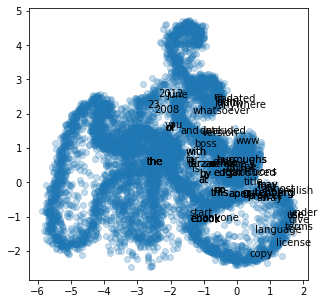

497819/497819 [==============================] - 121s 242us/sample - loss: 0.1325 - accuracy: 0.9356 - val_loss: 1.4905 - val_accuracy: 0.4919
Epoch 14/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9358
Epoch 00014: val_loss did not improve from 0.69315
Creating word embeddings...


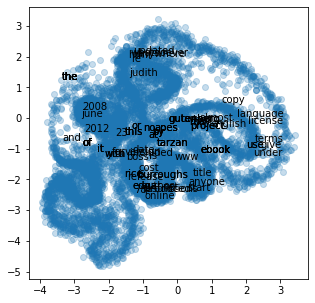

497819/497819 [==============================] - 121s 243us/sample - loss: 0.1303 - accuracy: 0.9358 - val_loss: 1.5028 - val_accuracy: 0.4935
Epoch 15/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9360
Epoch 00015: val_loss did not improve from 0.69315
Creating word embeddings...


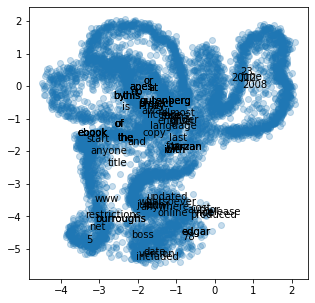

497819/497819 [==============================] - 120s 241us/sample - loss: 0.1285 - accuracy: 0.9360 - val_loss: 1.5322 - val_accuracy: 0.4912
Epoch 16/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9364
Epoch 00016: val_loss did not improve from 0.69315
Creating word embeddings...


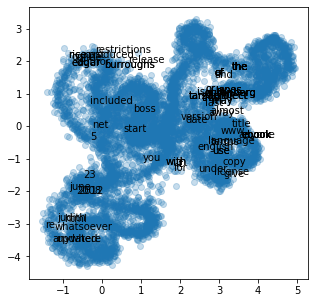

497819/497819 [==============================] - 120s 240us/sample - loss: 0.1269 - accuracy: 0.9364 - val_loss: 1.5558 - val_accuracy: 0.4924
Epoch 17/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9362
Epoch 00017: val_loss did not improve from 0.69315
Creating word embeddings...


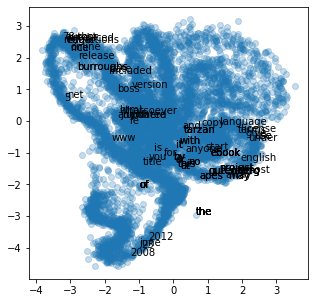

497819/497819 [==============================] - 119s 239us/sample - loss: 0.1256 - accuracy: 0.9362 - val_loss: 1.5749 - val_accuracy: 0.4915
Epoch 18/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9362
Epoch 00018: val_loss did not improve from 0.69315
Creating word embeddings...


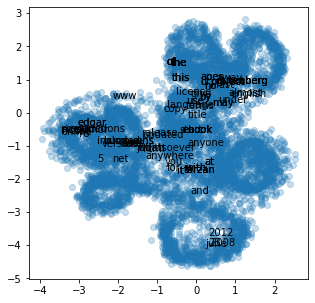

497819/497819 [==============================] - 120s 240us/sample - loss: 0.1242 - accuracy: 0.9362 - val_loss: 1.5942 - val_accuracy: 0.4924
Epoch 19/20
497664/497819 [============================>.] - ETA: 0s - loss: 0.1228 - accuracy: 0.9368
Epoch 00019: val_loss did not improve from 0.69315
Creating word embeddings...


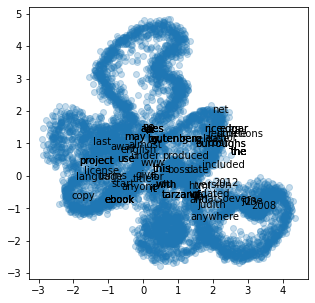

497819/497819 [==============================] - 120s 241us/sample - loss: 0.1228 - accuracy: 0.9368 - val_loss: 1.5947 - val_accuracy: 0.4939
Epoch 20/20
497792/497819 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9367
Epoch 00020: val_loss did not improve from 0.69315
Creating word embeddings...


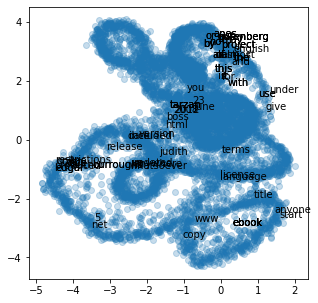

497819/497819 [==============================] - 120s 242us/sample - loss: 0.1217 - accuracy: 0.9367 - val_loss: 1.6015 - val_accuracy: 0.4904


In [43]:
# Define callbacks
checkpoint = ModelCheckpoint('checkpoints/model-best-{epoch:02d}.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')  
umap_reduc = IntermediateUMAPReductionCallback(data=book_data, rev_data_dictionary=rev_book_dictionary)
cb = [checkpoint, umap_reduc]

# Reshape X to fit Dense model
X_train_hot_resh = X_train_hot.reshape(2, X_train_hot.shape[0], real_vocab_size + 1)
X_val_hot_resh = X_val_hot.reshape(2, X_val_hot.shape[0], real_vocab_size + 1)
X_test_hot_resh = X_test_hot.reshape(2, X_test_hot.shape[0], real_vocab_size + 1)

# Uncomment to fit model
model_hist = w2v_model.fit(
    list(X_train_hot_resh),
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=cb,
    validation_data=(list(X_val_hot_resh), y_val)
)

In [ ]:
# TODO: Run a UMAP on all embeddings at once ((m x n) x 300 matrix)
# to get a less biased result. The plots above from training might be too correlated.

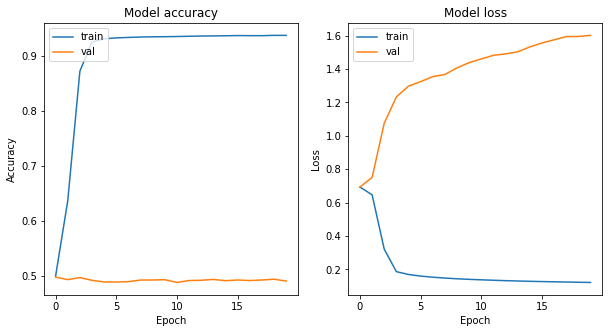

In [44]:
# Summarize history for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
# Evaluate train accuracy
y_train_pred = w2v_model.predict(list(X_train_hot_resh))
y_train_auc = roc_auc_score(y_train, y_train_pred)
print(f'Train AUC: {y_train_auc}')

Train accuracy: 0.994179299316593


In [50]:
# Evaluate test accuracy
y_test_pred = w2v_model.predict(list(X_test_hot_resh))
y_test_auc = roc_auc_score(y_test, y_test_pred)
print(f'Test AUC: {y_test_auc}')

Test accuracy: 0.4918765321544173


In [18]:
# Save last model to file
w2v_model.save('checkpoints/last_model.h5')

## Analyze word embeddings

In [19]:
# Load best model from file
#best_model_path = 'checkpoints/last_model.h5'
best_model_path = 'checkpoints/model-best-02.h5'
w2v_model = load_model(best_model_path)

In [51]:
# Extract the learned embeddings from the NN
word_embeddings = w2v_model.layers[2].get_weights()[0]
word_embeddings_lst = list(word_embeddings)

In [52]:
word_embeddings_2d = PCA(n_components=2).fit_transform(word_embeddings)

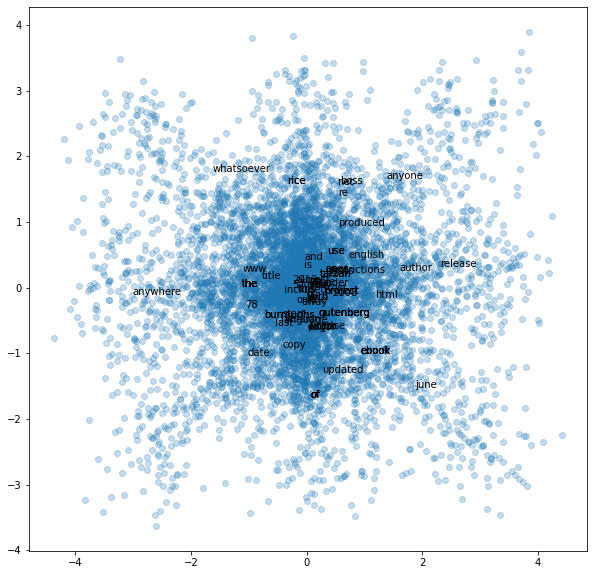

In [53]:
# Plot embedded vectors in 2D
plt.figure(figsize=(10, 10))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.25)

# Annotate
for word_i in book_data[:100]:
    word = rev_book_dictionary[word_i]
    word_vec = word_embeddings_2d[word_i]
    plt.annotate(word, (word_vec[0], word_vec[1]))
plt.show()

In [54]:
# Tarzan - Man + Woman = Jane?
tarzan_vec = word_embeddings[book_dictionary['tarzan']]
man_vec = word_embeddings[book_dictionary['man']]
woman_vec = word_embeddings[book_dictionary['woman']]
jane_vec = word_embeddings[book_dictionary['jane']]
jane_vec_pred = tarzan_vec - man_vec + woman_vec

### Utility functions

In [55]:
def distance(a: np.ndarray, b: np.ndarray):
    '''
    TODO: Docs
    '''
    return np.linalg.norm(a - b)

def closest(target: np.ndarray, word_embeddings: np.ndarray, rev_book_dictionary: dict, n: int=10):
    '''
    TODO: Docs
    '''
    target_mat = np.tile(target, (word_embeddings.shape[0], 1))
    diff = word_embeddings - target_mat
    distances = np.linalg.norm(diff, axis=1)
    sorted_order = np.argsort(distances)[:n]
    closest_words = [rev_book_dictionary[idx + 1] for idx in sorted_order]
    return closest_words

In [56]:
# TODO: Find top words close to jane_vec_pred
print(closest(jane_vec_pred, word_embeddings, rev_book_dictionary))

['why', 'him', 'recollected', 'the', 'deathly', 'been', 'of', 'this', 'haven', 'twice']


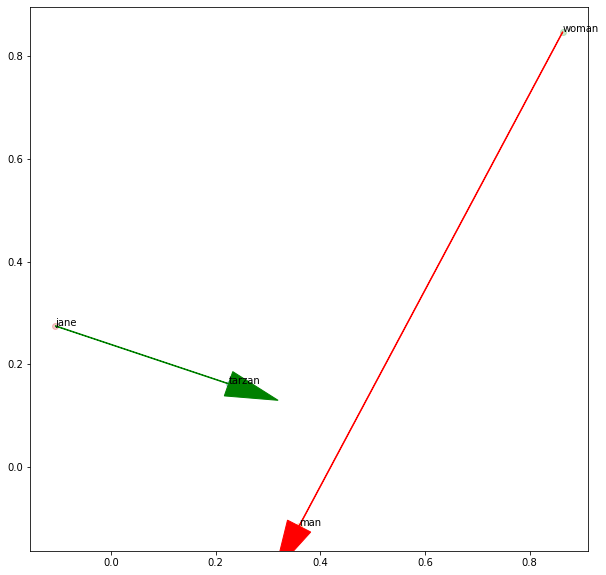

In [57]:
# TODO: Create utility function 'arrow_plot'
# Plotting tarzan, man, woman, jane
target_words = ['tarzan', 'man', 'woman', 'jane']
target_word_vecs = [word_embeddings_2d[book_dictionary[word]] for word in target_words]

# TODO: Ensure that we use a dim. reduc. method that preserves parallelism, i.e PCA
plt.figure(figsize=(10, 10))
for word, word_vec in zip(target_words, target_word_vecs):
    plt.scatter(word_vec[0], word_vec[1], alpha=0.25)
    plt.annotate(word, (word_vec[0], word_vec[1]))

man_to_woman = target_word_vecs[target_words.index('man')] - target_word_vecs[target_words.index('woman')]
tarzan_to_jane = target_word_vecs[target_words.index('tarzan')] - target_word_vecs[target_words.index('jane')]
plt.arrow(*target_word_vecs[target_words.index('woman')], *man_to_woman, head_width=0.05, head_length=0.1, color='r')
plt.arrow(*target_word_vecs[target_words.index('jane')], *tarzan_to_jane, head_width=0.05, head_length=0.1, color='g')
    
plt.show()

# Scrapyard

In [24]:
'''
def build_dataset(words: list, num_words: int = -1):
    
    # Create a dictionary for word counts
    count = [['UNK', -1]]
    if num_words == -1:
        num_words = len(words)
        
    # TODO: Fix words
    count.extend(collections.Counter(words).most_common(num_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return data, count, dictionary, reversed_dictionary
'''

"\ndef build_dataset(words: list, num_words: int = -1):\n    \n    # Create a dictionary for word counts\n    count = [['UNK', -1]]\n    if num_words == -1:\n        num_words = len(words)\n        \n    # TODO: Fix words\n    count.extend(collections.Counter(words).most_common(num_words - 1))\n    dictionary = dict()\n    for word, _ in count:\n        dictionary[word] = len(dictionary)\n    \n    data = list()\n    unk_count = 0\n    for word in words:\n        if word in dictionary:\n            index = dictionary[word]\n        else:\n            index = 0  # dictionary['UNK']\n            unk_count += 1\n        data.append(index)\n    count[0][1] = unk_count\n    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))\n\n    return data, count, dictionary, reversed_dictionary\n"